In [23]:
!git clone https://github.com/NinoXing/Self_Driving

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 30.66 MiB/s, done.
Checking out files: 100% (12160/12160), done.


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

np.random.seed(0)

In [0]:
datadir = 'Self_Driving'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'),names = columns)
#pd.set_option('display.max_colwidth', -1)

In [26]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_01_23_21_01_09_794.jpg,left_2019_01_23_21_01_09_794.jpg,right_2019_01_23_21_01_09_794.jpg,0.0,0.0,0.0,0.000079
1,center_2019_01_23_21_01_09_896.jpg,left_2019_01_23_21_01_09_896.jpg,right_2019_01_23_21_01_09_896.jpg,0.0,0.0,0.0,0.000080
2,center_2019_01_23_21_01_09_997.jpg,left_2019_01_23_21_01_09_997.jpg,right_2019_01_23_21_01_09_997.jpg,0.0,0.0,0.0,0.000080
3,center_2019_01_23_21_01_10_099.jpg,left_2019_01_23_21_01_10_099.jpg,right_2019_01_23_21_01_10_099.jpg,0.0,0.0,0.0,0.000080
4,center_2019_01_23_21_01_10_201.jpg,left_2019_01_23_21_01_10_201.jpg,right_2019_01_23_21_01_10_201.jpg,0.0,0.0,0.0,0.000078


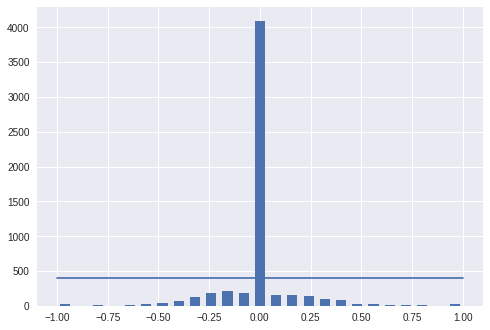

In [27]:
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:])*0.5
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))

total data 5730
removed 3689
remaining: 2041


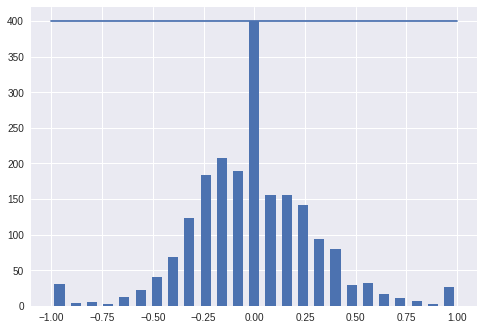

In [28]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)
        
print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace = True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width = 0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])),(samples_per_bin, samples_per_bin))           

In [29]:
def load_image_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0],indexed_data[1],indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_image_steering(datadir + '/IMG', data)
print(image_paths.shape)
print(steerings.shape)

(2041,)
(2041,)


In [30]:
X_train, X_valid, Y_train, Y_valid = train_test_split(image_paths, steerings, test_size = 0.2, random_state = 6)
print('Training data: {}\nValid data: {}'.format(len(X_train),len(X_valid)))

Training data: 1632
Valid data: 409


Text(0.5, 1.0, 'valid set')

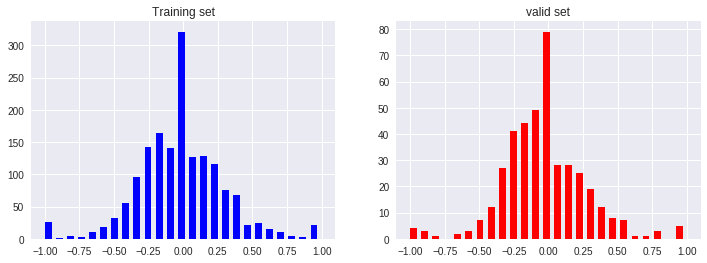

In [31]:
fig, axs = plt.subplots(1,2,figsize = (12,4))
axs[0].hist(Y_train, bins = num_bins, width = 0.05, color = 'b')
axs[0].set_title('Training set')
axs[1].hist(Y_valid, bins = num_bins, width = 0.05, color = 'r')
axs[1].set_title('valid set')

In [0]:
#preprocessing image
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle

def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle

In [0]:
def image_preprocessing(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = cv2.resize(img, (200,66))
    img = img/255
    return img

In [0]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = image_preprocessing(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

In [0]:
X_train_gen, Y_train_gen = next(batch_generator(X_train, Y_train, 1, 1))
X_valid_gen, Y_valid_gen = next(batch_generator(X_valid, Y_valid, 1, 0))

In [0]:
def nvidia_model():
    model = Sequential()
    model.add(Convolution2D(24, 5, 5, subsample = (2, 2), input_shape = (66, 200 ,3), activation = 'elu'))
    model.add(Convolution2D(36, 5, 5, subsample = (2, 2), activation = 'elu'))
    model.add(Convolution2D(48, 5, 5, subsample = (2, 2), activation = 'elu'))
    model.add(Convolution2D(64, 3, 3, activation = 'elu'))
    model.add(Convolution2D(64, 3, 3, activation = 'elu'))
    
    model.add(Flatten())
    model.add(Dense(100, activation = 'elu'))
    
    model.add(Dense(50, activation = 'elu'))
    
    model.add(Dense(10, activation = 'elu'))

    model.add(Dense(1))
    
    model.compile(Adam(lr = 1e-4), loss = 'mse')
    return model

In [43]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               115300    
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), input_shape=(66, 200, ..., activation="elu", strides=(2, 2))`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="elu", strides=(2, 2))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="elu", strides=(2, 2))`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="elu")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), act

In [44]:
 h = model.fit_generator(batch_generator(X_train, Y_train, 100, 1),
                                  steps_per_epoch=300,
                                  epochs=10,
                                  validation_data=batch_generator(X_valid, Y_valid, 100, 0),
                                  validation_steps=200,
                                  verbose=1,
                                  shuffle = 1)

Epoch 1/10
300/300 [==============================] - 170s 568ms/step - loss: 0.0827 - val_loss: 0.0535
Epoch 2/10
300/300 [==============================] - 165s 551ms/step - loss: 0.0719 - val_loss: 0.0492
Epoch 3/10
300/300 [==============================] - 165s 550ms/step - loss: 0.0636 - val_loss: 0.0462
Epoch 4/10
300/300 [==============================] - 166s 554ms/step - loss: 0.0558 - val_loss: 0.0456
Epoch 5/10
300/300 [==============================] - 166s 553ms/step - loss: 0.0542 - val_loss: 0.0336
Epoch 6/10
300/300 [==============================] - 165s 551ms/step - loss: 0.0486 - val_loss: 0.0354
Epoch 7/10
299/300 [============================>.] - ETA: 0s - loss: 0.0459

KeyboardInterrupt: ignored

In [0]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('train result')
plt.xlabel('epoch')
plt.legend(['loss','val_loss'])

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')